# Statistical Modelling

- I will use a hierarchical bayesian linear model like Twieki uses here: https://github.com/github/covid19-dashboard/blob/master/_notebooks/2020-03-16-covid19_growth_bayes.ipynb 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [2]:
## load the data
df_cases = pd.read_pickle('./corona_scotland_regions_ts.pk')
df_total = pd.read_pickle('./corona_scotland_total_stats.pk')

In [3]:
max_num_days = len(df_cases)
max_num_days

32

In [4]:
## remove cases where there are hardly any cases
drop_cols = df_cases.columns[df_cases.quantile(0.75) == 0.0]
print(drop_cols)

df_cases = df_cases.drop(columns=drop_cols)

Index(['Eileanan Siar (Western Isles)', 'Orkney'], dtype='object', name='Health Board')


In [5]:
regions = df_cases.columns.values[:-1]
n_regions = len(regions)

In [6]:
df_cases[regions[0]].values.nonzero()[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [7]:
## find starting days
starting_days = {c: np.flatnonzero(df_cases[c].values)[0] for c in regions}
starting_days

{'Ayrshire and Arran': 0,
 'Borders': 5,
 'Dumfries and Galloway': 10,
 'Fife': 0,
 'Forth Valley': 0,
 'Grampian': 0,
 'Greater Glasgow and Clyde': 0,
 'Highland': 8,
 'Lanarkshire': 1,
 'Lothian': 0,
 'Shetland': 3,
 'Tayside': 0}

### Create the Model

In [8]:
with pm.Model() as model:
    
    ### Intercepts ###
    # Group mean
    intr_grp = pm.Normal('intr_grp', 100, 50)
    # Group variance
    intr_grp_sigma = pm.HalfNormal('intr_grp_normal', 50)
    
    # Individual intercepts
    intr_ind = pm.Normal('intr_ind',
                          mu=intr_grp,
                          sigma=intr_grp_sigma,
                          shape=n_regions)
    
    
    ### Slopes ###
    # Group mean
    slope_grp = pm.Normal('slope_grp', 1.33, 0.5)
    # Group variance
    slope_grp_sigma = pm.HalfNormal('slope_grp_sigma', 0.5)
    
    # Individual slopes
    slope_ind = pm.Normal('slope_ind',
                          mu=slope_grp,
                          sigma=slope_grp_sigma,
                          shape=n_regions)
    
    ### Individual Error ###
    sigma = pm.HalfNormal('sigma', 500., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        cases_region = df_cases[region].values[starting_days[region]:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(0, max_num_days-starting_days[region], 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [10]:
with model:
    # Sample posterior
    trace = pm.sample(tune=1500, draws=1000, 
                      chains=1, cores=2, target_accept=0.9,
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, slope_ind, slope_grp_sigma, slope_grp, intr_ind, intr_grp_normal, intr_grp]
Sampling chain 0, 0 divergences: 100%|██████████| 2500/2500 [14:16<00:00,  2.92it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


In [11]:
import pickle

In [12]:
pickle.dump(trace, open('trace_0604.pk', 'wb'))
pickle.dump(model, open('pymc_model_0604.pk', 'wb'))

In [13]:
with model:
    # Update data so that we get predictions into the future
    for i, r in enumerate(regions):
        cases_region = df_cases[r].values[starting_days[r]:]
        x_data = np.arange(0, 40)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({r + 'x_data': x_data})
        pm.set_data({r + 'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


## Predicted Cases By Region

In [14]:
region_loc = {r: i for i,r in enumerate(regions)}

In [15]:
region_loc

{'Ayrshire and Arran': 0,
 'Borders': 1,
 'Dumfries and Galloway': 2,
 'Fife': 3,
 'Forth Valley': 4,
 'Grampian': 5,
 'Greater Glasgow and Clyde': 6,
 'Highland': 7,
 'Lanarkshire': 8,
 'Lothian': 9,
 'Shetland': 10,
 'Tayside': 11}

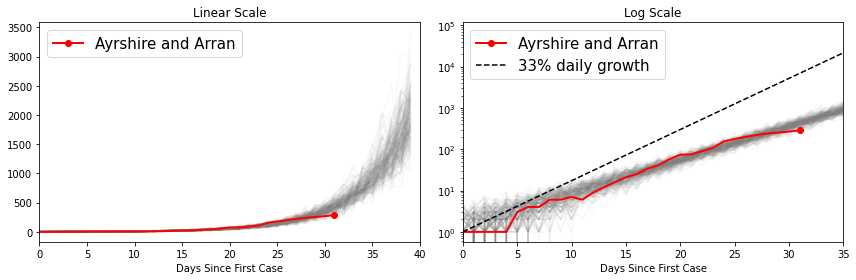

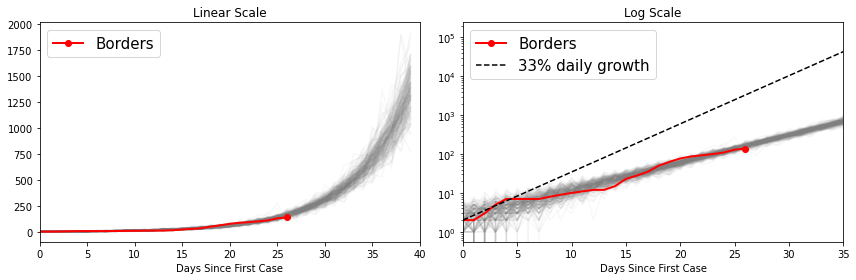

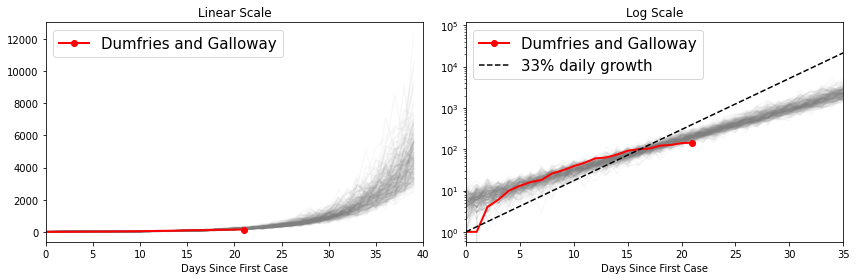

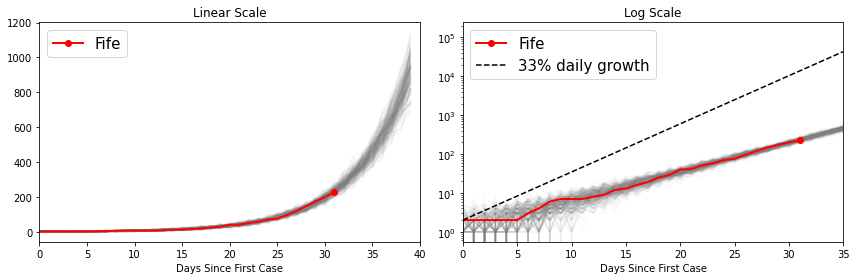

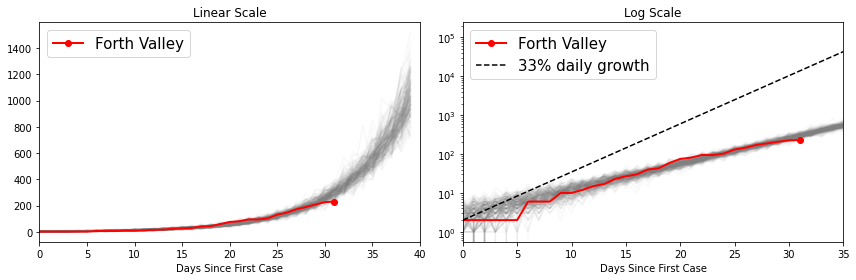

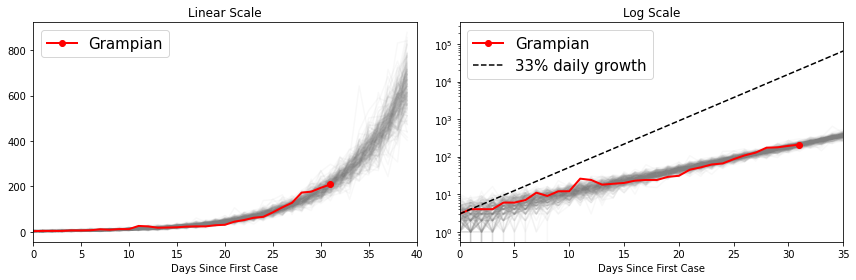

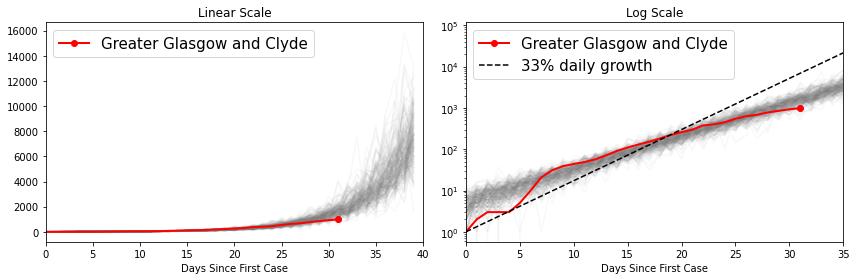

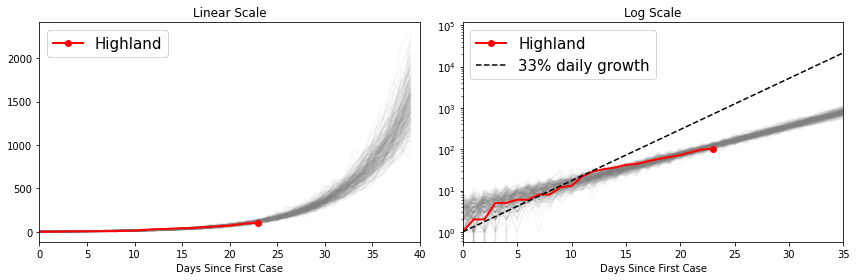

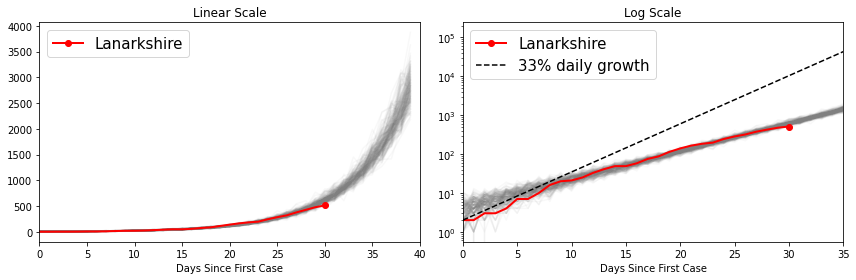

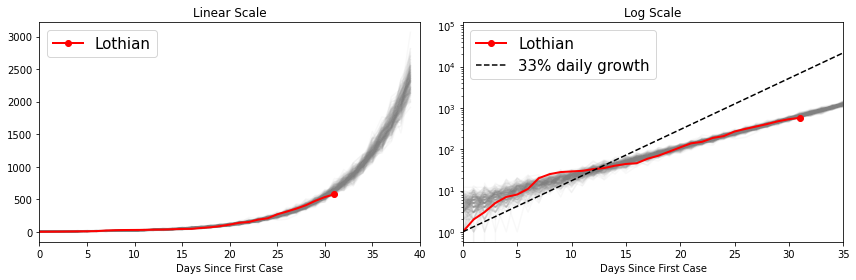

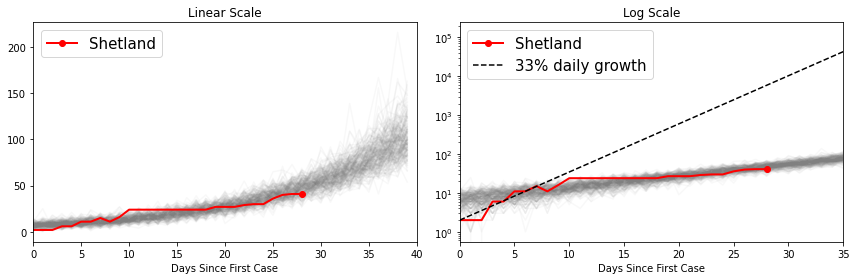

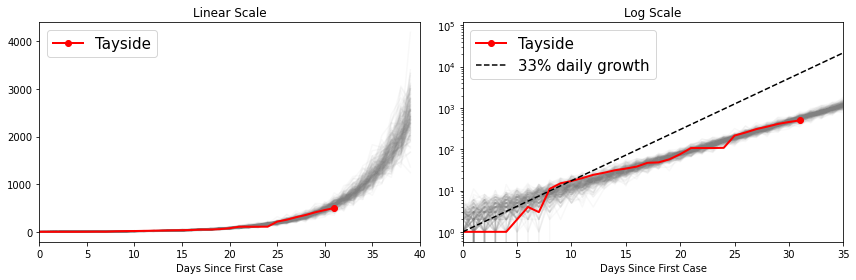

In [16]:
for r in regions:
    y = df_cases[r].iloc[starting_days[r]:].values

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))

    ax = axes[0]
    for sim in post_pred[r]:
        ax.plot(sim, color='gray', alpha=0.05)
    ax.plot(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    #ax.plot(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(0, 40)
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Linear Scale')
    ax.legend(fontsize=15)

    ax = axes[1]
    for sim in post_pred[r]:
        ax.semilogy(sim, color='gray', alpha=0.05)
    ax.semilogy(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.semilogy(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(0, 35)
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Log Scale')
    ax.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()
    

## Posterior Growth Rates Per Region

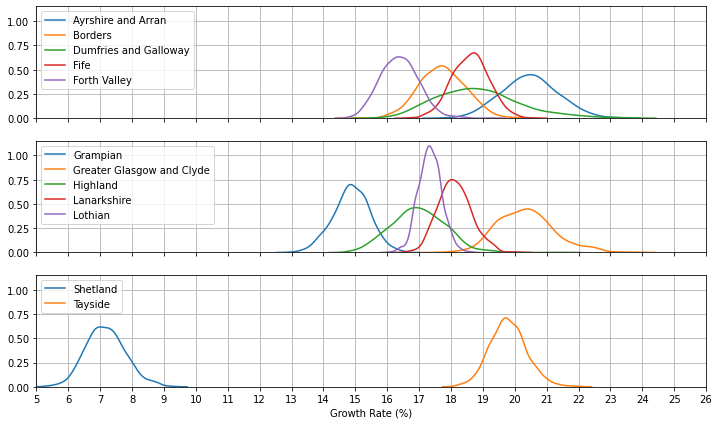

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharey=True, sharex=True)

for i in range(3):
    ax = axes[i]
    ax.grid()
    for r in regions[i*5: (i+1)*5]:
        sns.distplot((trace['slope_ind'][:, region_loc[r]] * 100 - 100), label=r, hist=False, ax=ax)
        ax.legend(loc=2)
    
ax.set_xlabel('Growth Rate (%)') 
ax.set_xticks(np.arange(0, 30))
ax.set_xlim(5, 26)
plt.show()

Confidence intervals of growth rates for each region.

(Orkney and Western Isles ommitted due to lack of data)

In [18]:
for r in regions:
    print(f"{r} : \t {pm.stats.hpd(trace['slope_ind'][:, region_loc[r]])}")

Ayrshire and Arran : 	 [1.1884274  1.22115942]
Borders : 	 [1.16426037 1.19072978]
Dumfries and Galloway : 	 [1.16708975 1.21500525]
Fife : 	 [1.17509975 1.19632427]
Forth Valley : 	 [1.15297307 1.17446351]
Grampian : 	 [1.13792636 1.1592359 ]
Greater Glasgow and Clyde : 	 [1.18845153 1.22197999]
Highland : 	 [1.15410181 1.1843081 ]
Lanarkshire : 	 [1.17190892 1.19084344]
Lothian : 	 [1.16737303 1.1804572 ]
Shetland : 	 [1.0612308  1.08385665]
Tayside : 	 [1.18702031 1.20842045]


## Model Diagnostics

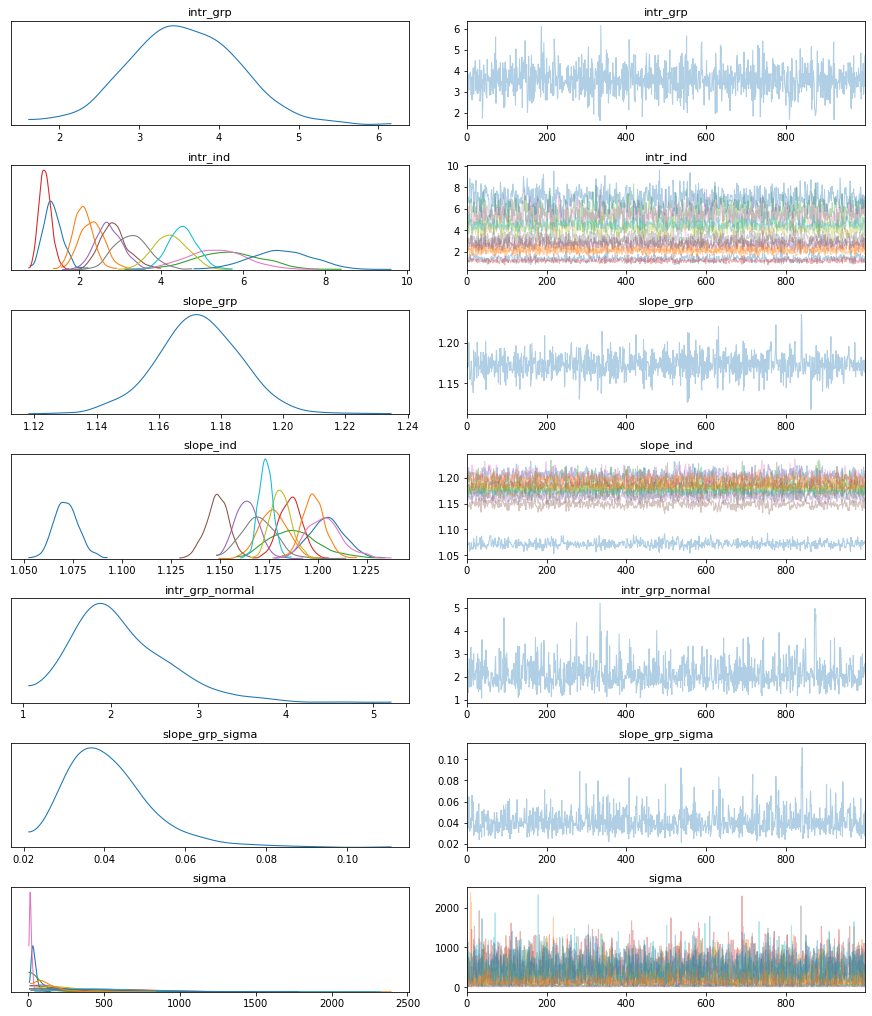

In [19]:
az.plot_trace(trace, compact=True);